In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask.array as da
import time
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import math
import pywt
import scipy
from scipy import ndimage

In [2]:
#Change viewing options
from IPython.core.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

In [3]:
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client

Client Scheduler: tcp://127.0.0.1:44865 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 6.24 GB


In [4]:
#Bring in the whole dataset
start = time.time()
ds = xr.open_mfdataset('/home/ddesantis/Downloads/livneh_NAmerExt_15Oct2014.*.mon.nc')
end = time.time()
print(end - start)

14.16968584060669


# Prepare data for processing

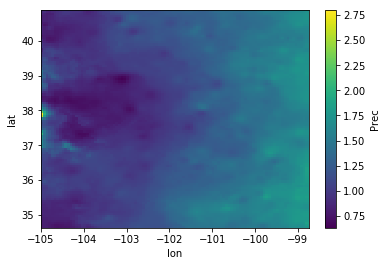

In [5]:
#Create a sub DataArray over smaller area; view some of the data to make sure not all NAN
ds2 = ds.isel(lat=slice(320,420), lon=slice(320,420), time=slice(0,200))
ds2.Prec.mean('time').plot()

# The following is one level of MRA Cluster:

In [58]:
#pywt.wavelist()
#Information : http://wavelets.pybytes.com/
print(pywt.Wavelet('db3'))

Wavelet db3
  Family name:    Daubechies
  Short name:     db
  Filters length: 6
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


In [67]:
#Set the number of levels for DWT, as well as the wavelet
min_len = min(ds2.Prec.data.shape)
levels = 1
wave = 'db3'

#figure out max possible levels to loop over given size of data
max_level = pywt.dwt_max_level(data_len = min_len, filter_len = pywt.Wavelet(wave).dec_len) 
max_level

4

# Compute DWT

In [68]:
#Compute the DWT

wp = pywt.wavedecn(data=ds2.Prec.data, wavelet=wave, level = min(levels,max_level))

In [85]:
wp[0].shape

(102, 52, 52)

In [177]:
wp[0][0][0]

array([0.1261869 , 0.11466135, 0.11760874, 0.13059069, 0.1432481 ,
       0.14796335, 0.15513054, 0.1643444 , 0.15535906, 0.12470907,
       0.10389287, 0.07369196, 0.07538424, 0.10921448, 0.13590086,
       0.15141056, 0.17727257, 0.18248294, 0.18660417, 0.2094544 ,
       0.23669234, 0.2733521 , 0.28252673, 0.28556228, 0.30728263,
       0.42142007, 0.47157136, 0.50846577, 0.5340693 , 0.5473999 ,
       0.6596059 , 0.7228061 , 0.7522807 , 0.79002124, 1.2887186 ,
       1.5989239 , 1.7347255 , 1.7829518 , 1.9422197 , 1.9949356 ,
       2.0741866 , 2.4415677 , 2.6805587 , 2.5992603 , 2.3523345 ,
       1.9173269 , 1.7489166 , 1.6425014 , 1.6583992 , 1.8043387 ,
       1.9487627 , 2.360833  ], dtype=float32)

# Cluster data at chosen level using DBScan

In [69]:
#Reshape the data
shaped = np.reshape(wp[0], (wp[0].shape[0], wp[0].shape[1]*wp[0].shape[2]))
shaped = np.transpose(shaped)
shaped.shape

(2704, 102)

In [70]:
#Remove nan values to cluster.  MAKE INTO FUNCTION
data = []
index = []
index_nan = []
count = 0
for p in range(shaped.shape[0]):
    if np.isnan(shaped[p][0]):  #check if nan
        index_nan.append(count)
        count = count +1
    else:
        data.append(shaped[p])
        index.append(count)
        count = count + 1       

In [72]:
%time data = da.stack(data, axis=0)

CPU times: user 457 ms, sys: 25.3 ms, total: 482 ms
Wall time: 414 ms


In [73]:
data.shape

(2704, 102)

In [74]:
#Discover the epsilon for DBScan using knn.  May want to alter the metric.  
# THIS SEEMS SLOW, SPEED UP
nbrs = NearestNeighbors(3, algorithm='ball_tree').fit(data)
distances, indices = nbrs.kneighbors(data)

#Set the distance to use as within 98th percentile:
epsilon = np.percentile(distances[:,[1,-1]], 98)

In [75]:
#Choose the min cluster size.  This is done by setting a percent of the size of the DWT coefficents (as long as it is
# at least 2).

ratio_dwt = 0.001

min_size = max(np.ceil(data.shape[0]*ratio_dwt), 2)
min_size

3.0

In [76]:
#Perform db scan and return the result
classes = DBSCAN(eps=epsilon, min_samples=min_size).fit_predict(data)

In [77]:
classes

array([0, 0, 0, ..., 0, 0, 0])

In [78]:
classes.shape

(2704,)

In [79]:
np.max(classes)

10

In [80]:
#Thread the NAN values back in with classes:

#MAKE A FUNCTION

#Build the nan array
classes_nan = np.ones(len(index_nan))*np.nan
classes = np.append(classes, classes_nan)


index_all = index + index_nan
index_all = np.array(index_all)

classes = classes[np.argsort(index_all)]

In [83]:
#Reshape classes to match back up with original
classes = np.reshape(classes, (wp[0].shape[1], wp[0].shape[2]))

In [84]:
classes.shape

(52, 52)

# Find all DWT  coeff. that are associated with data point x

In [1159]:
def class_indexer_even(fil_len, N_pts):
    """This function discovers which data values the DWT coefficients come from.  
    **Requires even length filter**
    **Requires even length data**
    """
   #Build vector to make id matrix:  This will have to change once we understand odd length
    a = np.ones(int(fil_len/2))
    b = np.zeros(int((N_pts - fil_len)/2))
    c = np.concatenate((a,b), axis=0)

    #Construct the identification matrix.  This is done by finding three matrix components needed -
    #I_m is middle, I_t is the top, and the bottom is a flip of I_t.
    
    #Build circulent matrix from c
    m1 = scipy.linalg.circulant(c)
    m1 = np.tril(m1,1)
    m1 = np.repeat(m1, repeats = 2, axis=1)
    #The middle of the index comes from bottom of this matrix
    I_m = m1[int(fil_len/2)-1:]
    
    #Grab the top
    m2 = m1[:int(fil_len/2)-1]  
    
    #Build the top of the index by dealing with reflection
    if int(fil_len)%4 == 0:
        mt = m2[int(fil_len/4) -1:]
        mt2 =  m2[int(fil_len/4):]
        I_t = np.concatenate(( np.flip(mt,axis=0),mt2), axis=0)
    else:
        mt = m2[int(fil_len/4):]
        I_t = np.concatenate(( np.flip(mt,axis=0),mt), axis=0)
    
    class_index = np.concatenate((I_t,I_m,np.flip(I_t,axis=1)), axis=0)
    
    return  class_index

In [1113]:
def class_indexer_odd(fil_len, N_pts):
    """This function discovers which data values the DWT coefficients come from.  
    **Requires even length filter**
    **Requires odd length data**
    """
    #Build vector to make id matrix:  This will have to change once we understand odd length
    a = np.ones(int(fil_len/2))
    b = np.zeros(int((N_pts - fil_len)/2))
    c = np.concatenate((a,b), axis=0)

    #Construct the identification matrix.  This is done by finding three matrix components needed -
    #I_m is middle, I_t is the top, and the bottom is I_b.
    
    #Build circulent matrix from c
    m1 = scipy.linalg.circulant(c)
    m1 = np.tril(m1,1)
    m1 = np.repeat(m1, repeats = 2, axis=1)
    m1 = np.insert(m1,m1.shape[1],0,axis=1)
    #The middle of the index comes from bottom of this matrix
    I_m = m1[int(fil_len/2)-1:]
    
    #Grab the top
    m2 = m1[:int(fil_len/2)-1]  
    
    #Build the top of the index by dealing with reflection
    if int(fil_len)%4 == 0:
        mt = m2[int(fil_len/4) -1:]
        mt2 =  m2[int(fil_len/4):]
        I_t = np.concatenate(( np.flip(mt,axis=0),mt2), axis=0)
    else:
        mt = m2[int(fil_len/4):]
        I_t = np.concatenate(( np.flip(mt,axis=0),mt), axis=0)
    
    #Build the bottom of the index
    if int(fil_len)%4 == 0:
        if fil_len == 4:
            mt = m2[:]
            mt = np.insert(mt,0,1,axis=1)
            mt = np.concatenate((np.flip(mt,axis=0),mt),axis=0)
            I_b = np.flip(mt,axis=1)
            I_b = np.delete(I_b,0,axis=1)
        else:
            mt = m2[1:]
            mt = np.insert(mt,0,1,axis=1)
            mt = np.concatenate((np.flip(mt,axis=0),mt),axis=0)
            I_b = np.flip(mt,axis=1)
            I_b = np.delete(I_b,0,axis=1)
    else:
        mt = m2[int(fil_len/4) -1:]
        mt = np.insert(mt,0,1,axis=1)
        mt = np.concatenate((np.flip(mt[1:],axis=0),mt),axis=0)
        I_b = np.flip(mt,axis=1)
        I_b = np.delete(I_b,0,axis=1)
        
        
    class_index = np.concatenate((I_t,I_m), axis=0)
    class_index = np.concatenate((class_index,I_b), axis=0)
    return  class_index

In [1126]:
def class_indexer(fil_len, signal):
    if signal.size%2 == 0:
        class_index = class_indexer_even(fil_len, signal.size)
    else:
        class_index = class_indexer_odd(fil_len, signal.size)
        
    return class_index

# Determine the class at point x

In [1161]:
ex = np.array(range(9))
w = pywt.dwt(ex, wavelet="db2")
w[0].shape

(6,)

In [1162]:
pywt.Wavelet('db2').dec_lo

[-0.12940952255126037,
 0.2241438680420134,
 0.8365163037378079,
 0.48296291314453416]

In [1165]:
ww = np.reshape(w[0],(1,6))
ww

array([[ 0.35355339,  0.89657547,  3.7250026 ,  6.55342972,  9.51126637,
        11.34838368]])

In [1166]:
class_index = class_indexer(4,ex)
class_index

array([[1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1.]])

In [1130]:
np.w[0]*class_index

ValueError: operands could not be broadcast together with shapes (6,) (6,9) 

In [662]:
filter_matrix = np.array([
    [ 0.48296291, 0.8365163,  0.22414387, -0.12940952,  0,0,0,0,0],
    [0,0, 0.48296291, 0.8365163,  0.22414387, -0.12940952,  0,0,0],  
    [ 0,0, 0,0, 0.48296291, 0.8365163,  0.22414387, -0.12940952, 0],
    [ 0,0, 0,0, 0, 0, 0.48296291, 0.8365163,  0.22414387 + -0.12940952 ],
                         ])

In [663]:
print(ex.shape)
print(filter_matrix.shape)

(9,)
(4, 9)


In [664]:
np.matmul(filter_matrix,ex)

array([0.89657548, 3.7250026 , 6.55342972, 9.51126636])

In [631]:
def mean_replace(a):
    """This function takes a matrix of 1's and 0's and replaces the 1 values with the row average"""
    class_index_weight = np.sum(a, axis=1)
    class_index_weight = class_index_weight**(-1)
    class_index_weight = np.reshape(class_index_weight, (class_index_weight.size,1))
    class_index_weight
    return class_index_weight*a

# Map classes back to (lat,lon) points

In [86]:
#The following is to handle DWT where filter length is not 2:

In [108]:
#Construct an index for class mapping:
#Assumes that the length of the filter is even - often (always?) case for orthogonal wavelets
filter_len = pywt.Wavelet(wave).dec_len
ind_len = int(filter_len/2)
ind_even = np.array(range(ind_len))*2
ind_odd = np.array(range(ind_len))*2 + 1

In [157]:
#The following function determines the class for a data point k if multiple classes exist:
def class_number(a):
    mu = np.mean(a)
    sigma = np.std(a)
    return mu + (np.std(example))/np.sqrt(len(a))

In [172]:
example = np.array([0,2, 4])
example

array([0, 2, 4])

In [173]:
val = class_number(example)
val

2.9428090415820636

# Map back for the Haar wavelet

In [62]:
#In general, the inverse map will depend on the choice of wavelet.
#For now, we only use the Haar wavelet
#Also, only works for origoinal data selected to have even size (odd size need to adjust)

In [29]:
np.repeat(np.repeat(classes, repeats = 2, axis=0), repeats = 2, axis=1)

In [35]:
for j in range(min(levels, max_level)):
    classes = np.repeat(np.repeat(classes, repeats = 2, axis=0), repeats = 2, axis=1)

In [65]:
classes.shape

(200, 200)

# Discover Final Classes

In [61]:
# For each resolution, we get a classes array. The class label is a vector (l_1, ... l_K), where K is the number of 
# levels computed. 

In [398]:
def filter_out_nan(shaped):
    '''This function filters out nan values from a matrix nxm, and saves the index for threading back together'''
    data = []
    index = []
    index_nan = []
    count = 0
    for p in range(shaped.shape[0]):
        if np.isnan(shaped[p][0]):  #check if nan
            index_nan.append(count)
            count = count +1
        else:
            data.append(shaped[p])
            index.append(count)
            count = count + 1    
            
    data = da.stack(data, axis=0)
    return data, index, index_nan

In [399]:
def filter_in_nan(classes, index, index_nan):
    '''The inverse function of filter_out_nan - used to put nan values back into set after clustering'''
    classes_nan = np.ones(len(index_nan))*np.nan
    classes = np.append(classes, classes_nan)


    index_all = index + index_nan
    index_all = np.array(index_all)

    classes = classes[np.argsort(index_all)]
    
    return classes

In [409]:
#Function to compute single level for feature data
def single_level_class(data_set, feature, level, wavelet='haar', metric='euclidean', n_neighbors=3, eps_percentile=98, ratio_dwt=0.001):
    '''The following code computes one level of WaveScan'''
    
    startt=time.time()
    
    lvl = str(level)
    print("LEVEL: " + lvl)
    
    #Compute DWT
    start = time.time()
    wp = pywt.wavedecn(data=data_set[feature].data, wavelet=wave, level = min(level,max_level), mode='constant')
    end = time.time()
    diff = str(end-start)
    print("DWT:" + diff)
    
    #Reshape the data for DBScan
    start = time.time()
    shaped = np.reshape(wp[0], (wp[0].shape[0], wp[0].shape[1]*wp[0].shape[2]))
    shaped = np.transpose(shaped)
    shaped.shape
    
    #Filter out the nan values for clustering
    data, index, index_nan = filter_out_nan(shaped)
    
    end = time.time()
    diff = str(end-start)
    print("Prep Data:" + diff)
    #Discover the epsilon for DBScan using knn. 
    start = time.time()
    
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)

    #Set the distance to use as within eps_percentile:
    epsilon = np.percentile(distances[:,[1,-1]], eps_percentile)
    
    #Choose the min cluster size.  This is done by setting a percent of the size of the DWT coefficents (as long as it is
    # at least 2).
    min_size = max(np.ceil(data.shape[0]*ratio_dwt), 2)
    end = time.time()
    diff = str(end-start)
    print("Find Params:" + diff)
    
    #Perform db scan and return the result
    start = time.time()
    classes = DBSCAN(eps=epsilon, min_samples=min_size, metric=metric).fit_predict(data)
    end = time.time()
    diff = str(end-start)
    print("DBSCAN:" + diff)
    
    #Filter back in the nan values before reshaping:
    start = time.time()
    classes = filter_in_nan(classes, index, index_nan)
    
    #Reshape classes to match back up with original
    classes = np.reshape(classes, (wp[0].shape[1], wp[0].shape[2]))
    
    #In general, the inverse map will depend on the choice of wavelet.
    #For now, we only use the Haar wavelet
    #Also, only works for origoinal data selected to have even size (odd size need to adjust)
    
    #Inflate data back to original size:
    for j in range(min(level, max_level)):
        classes = np.repeat(np.repeat(classes, repeats = 2, axis=0), repeats = 2, axis=1)
    
    end = time.time()
    diff = str(end-start)
    print("Find Classes:" + diff)
    
    
    endt = time.time()
    difft = str(endt - startt)
    print("TOTAL: " + difft)
    print("")
    
    return classes

In [638]:
%who_ls

['Client',
 'DBSCAN',
 'N_pts',
 'NearestNeighbors',
 'Prec_classes',
 'Tmax_classes',
 'Tmin_classes',
 'a',
 'b',
 'c',
 'class_index',
 'class_index_mean',
 'class_index_weight',
 'class_indexer',
 'class_number',
 'classes',
 'classes_nan',
 'client',
 'count',
 'da',
 'data',
 'data_length',
 'dist',
 'distances',
 'ds',
 'ds2',
 'end',
 'epsilon',
 'ex',
 'ex2',
 'ex3',
 'example',
 'fil_len',
 'filter_in_nan',
 'filter_len',
 'filter_length',
 'filter_out_nan',
 'filterb',
 'i',
 'ind_even',
 'ind_len',
 'ind_odd',
 'index',
 'index_all',
 'index_nan',
 'indices',
 'levels',
 'm1',
 'm2',
 'm3',
 'm4',
 'm5',
 'm52',
 'm6',
 'math',
 'max_level',
 'mean_replace',
 'metrics',
 'min_len',
 'min_size',
 'mu',
 'nbrs',
 'ndimage',
 'np',
 'p',
 'pd',
 'plt',
 'pywt',
 'ratio_dwt',
 'scipy',
 'sfilter',
 'shaped',
 'single_level_class',
 'start',
 't',
 'time',
 'val',
 'w',
 'wave',
 'wp',
 'wpex',
 'wt',
 'xr']

In [411]:
#Gather all the Prec classes for each level:
%reset_selective -f Prec_classes

Prec_classes = []
for i in range(1,max_level+1):
    classes = single_level_class(ds2, feature = 'Prec', level = i)
    Prec_classes.append(classes)

LEVEL: 1
DWT:0.7269186973571777
Prep Data:0.80269455909729
Find Params:14.974904298782349


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


DBSCAN:7.423191547393799
Find Classes:0.0006241798400878906
TOTAL: 23.93174695968628

LEVEL: 2
DWT:1.1361570358276367
Prep Data:0.12446784973144531


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


Find Params:4.50823187828064


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


DBSCAN:2.262827157974243
Find Classes:0.0002613067626953125
TOTAL: 8.032644271850586

LEVEL: 3
DWT:0.9019043445587158
Prep Data:0.039400577545166016


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


Find Params:1.6580777168273926
DBSCAN:0.6380722522735596
Find Classes:0.0002751350402832031
TOTAL: 3.2426888942718506

LEVEL: 4
DWT:0.8526120185852051
Prep Data:0.01661205291748047
Find Params:0.5406785011291504
DBSCAN:0.2504730224609375
Find Classes:0.00027942657470703125
TOTAL: 1.6653032302856445



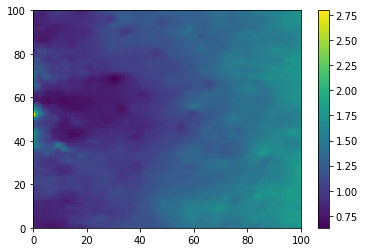

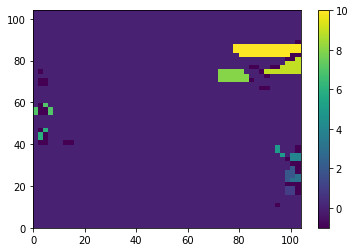

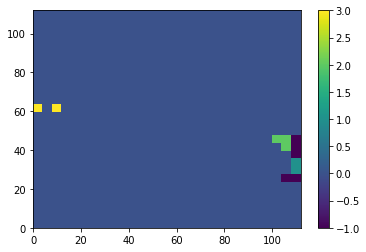

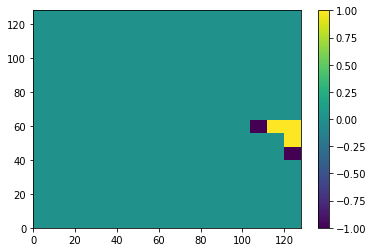

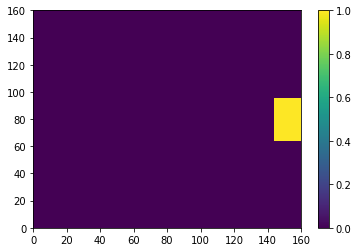

In [402]:
#Plot the different levels of classification verses the historical average:
plt.figure(-1)
p = plt.pcolormesh(ds2.Prec.mean('time').data)
plt.colorbar(p)

for i in range(0,max_level):
    plt.figure(i)
    p = plt.pcolormesh(Prec_classes[i])
    plt.colorbar(p)

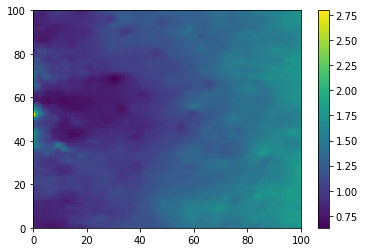

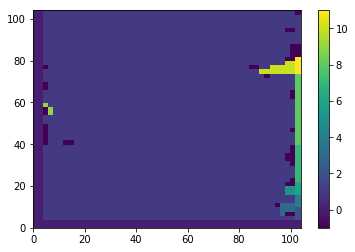

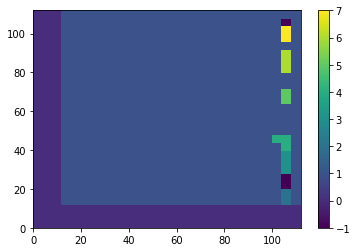

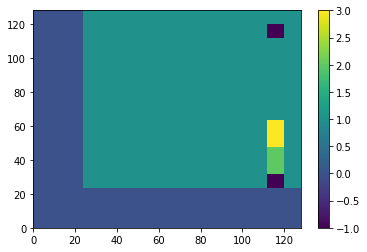

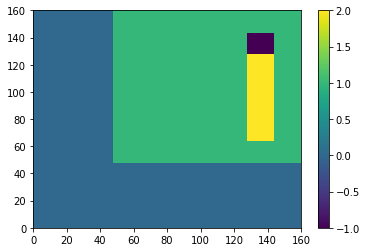

In [408]:
#Plot the different levels of classification verses the historical average:
plt.figure(-1)
p = plt.pcolormesh(ds2.Prec.mean('time').data)
plt.colorbar(p)

for i in range(0,max_level):
    plt.figure(i)
    p = plt.pcolormesh(Prec_classes[i])
    plt.colorbar(p)

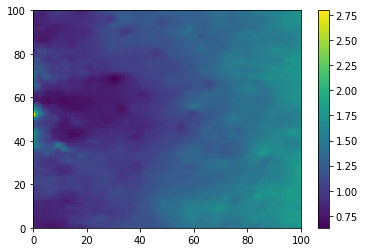

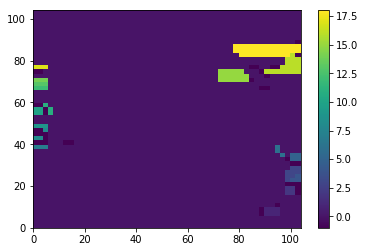

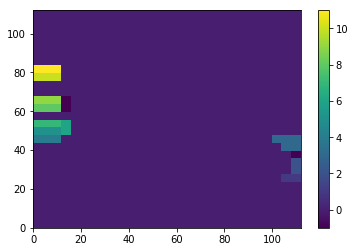

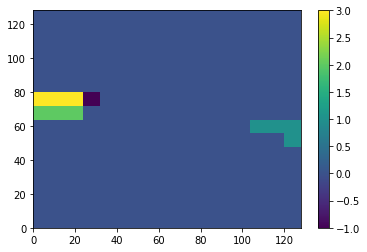

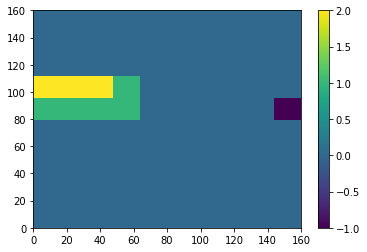

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


In [412]:
#Plot the different levels of classification verses the historical average:
plt.figure(-1)
p = plt.pcolormesh(ds2.Prec.mean('time').data)
plt.colorbar(p)

for i in range(0,max_level):
    plt.figure(i)
    p = plt.pcolormesh(Prec_classes[i])
    plt.colorbar(p)

In [ ]:
#The runtime for complete DBSCAN is approximately 0.008 sec per wavelet coefficent

In [54]:
#Gather all the Tmax classes for each level:
%reset_selective -f Tmax_classes

Tmax_classes = []
for i in range(1,max_level+1):
    classes = single_level_class(ds2, feature = 'Tmax', level = i)
    Tmax_classes.append(classes)

LEVEL: 1
DWT:3.8222508430480957
Find Params:13.652759790420532
DBSCAN:6.635314702987671
Find Classes:0.0006120204925537109
TOTAL: 24.526331424713135

LEVEL: 2
DWT:1.1973695755004883
Find Params:3.1859943866729736
DBSCAN:1.9489948749542236
Find Classes:0.0004596710205078125
TOTAL: 6.431339263916016

LEVEL: 3
DWT:0.8540074825286865
Find Params:0.8393707275390625
DBSCAN:0.8564105033874512
Find Classes:0.0005085468292236328
TOTAL: 2.5780279636383057

LEVEL: 4
DWT:0.8486964702606201
Find Params:0.3427920341491699
DBSCAN:0.19723749160766602
Find Classes:0.0004267692565917969
TOTAL: 1.3979322910308838

LEVEL: 5
DWT:0.8587949275970459
Find Params:0.19254255294799805
DBSCAN:0.1033639907836914
Find Classes:0.0002579689025878906
TOTAL: 1.1580455303192139

LEVEL: 6
DWT:0.7594153881072998
Find Params:0.09474468231201172
DBSCAN:0.045145273208618164
Find Classes:0.00021314620971679688
TOTAL: 0.9006311893463135



In [37]:
#Gather all the Tmin classes for each level:
%reset_selective -f Tmin_classes

Tmin_classes = []
for i in range(1,max_level+1):
    classes = single_level_class(ds2, feature = 'Tmin', level = i)
    Tmin_classes.append(classes)

LEVEL: 1
DWT:1530032732.1954
Find Params:1530032732.8897352
DBSCAN:1530032733.1522565
Find Classes:1530032733.1524909
TOTAL:1530032733.1526845

LEVEL: 2
DWT:1530032733.327849
Find Params:1530032733.5221395
DBSCAN:1530032733.6155932
Find Classes:1530032733.6158245
TOTAL:1530032733.615934

LEVEL: 3
DWT:1530032733.7805564
Find Params:1530032733.9066567
DBSCAN:1530032733.9579625
Find Classes:1530032733.9582014
TOTAL:1530032733.9582875

LEVEL: 4
DWT:1530032734.1027274
Find Params:1530032734.1800966
DBSCAN:1530032734.2153542
Find Classes:1530032734.2155178
TOTAL:1530032734.2155962



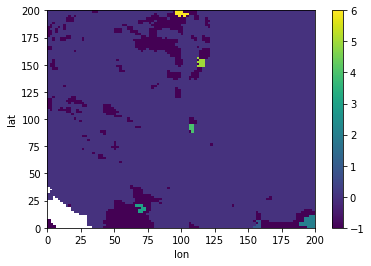

In [87]:
plt.figure(1)
plt.xlabel('lon')
plt.ylabel('lat')
p = plt.pcolormesh(Prec_classes[0])
plt.colorbar(p)

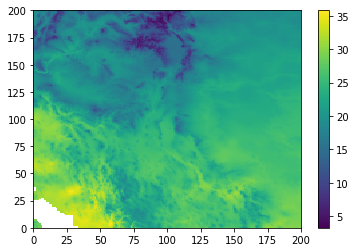

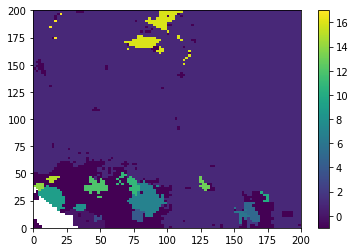

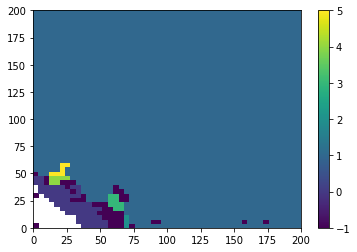

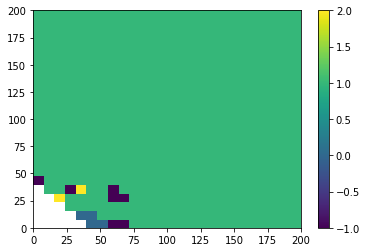

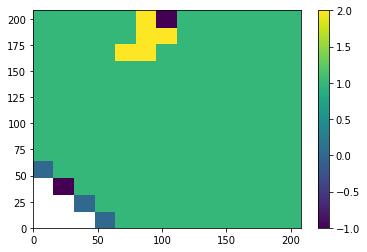

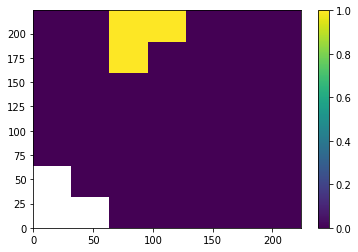

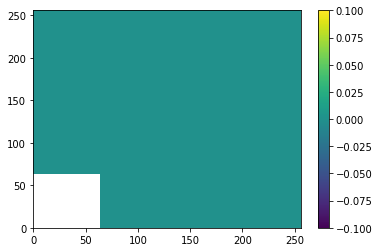

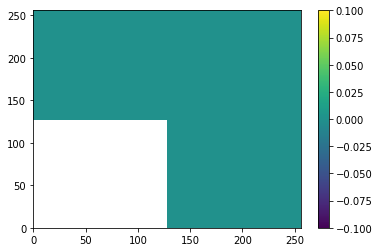

In [89]:
plt.figure(-1)
p = plt.pcolormesh(ds2.Tmax.mean('time').data)
plt.colorbar(p)

for i in range(0,max_level):
    plt.figure(i)
    p = plt.pcolormesh(Tmax_classes[i])
    plt.colorbar(p)

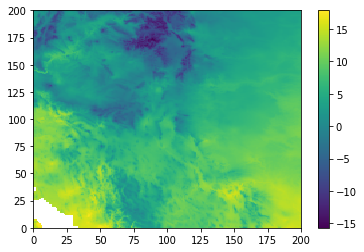

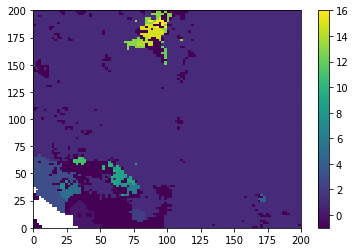

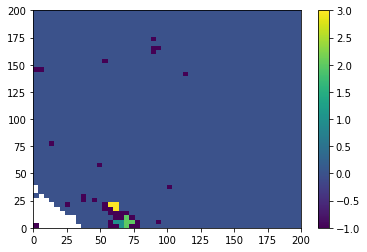

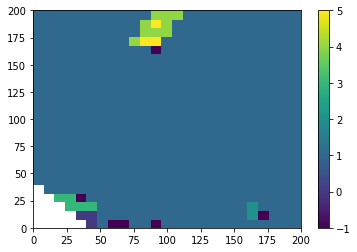

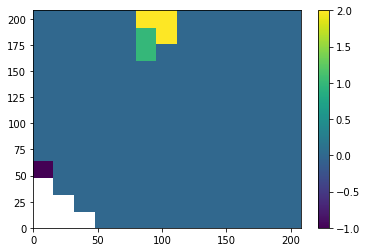

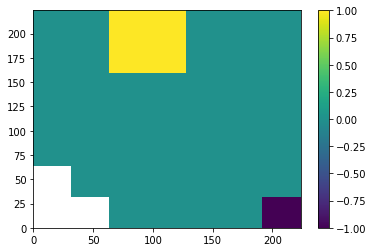

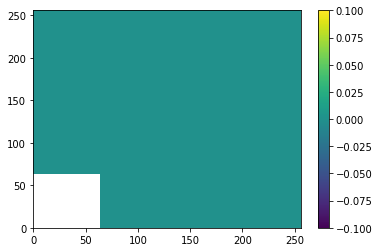

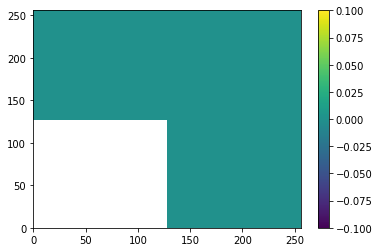

In [90]:
plt.figure(-1)
p = plt.pcolormesh(ds2.Tmin.mean('time').data)
plt.colorbar(p)

for i in range(0,max_level):
    plt.figure(i)
    p = plt.pcolormesh(Tmin_classes[i])
    plt.colorbar(p)

In [62]:
Tmin_classes[4]

array([[nan, nan, nan, ..., -1., -1., -1.],
       [nan, nan, nan, ..., -1., -1., -1.],
       [nan, nan, nan, ..., -1., -1., -1.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

# The following is to test to see if I am getting any mixed classes

In [198]:
ex = np.stack(Prec_classes, axis=0)
ex.shape

(6, 100, 100)

In [203]:
ex[:,5,5]

array([0., 0., 0., 0., 0., 0.])

In [166]:
ex2 = np.sum(ex,axis=0)

In [167]:
np.max(ex2)

14.0

In [169]:
np.histogram(ex2, bins=21)

(array([ 2580,     0,     0,     0,     0,     0,     0, 37160,     0,
            0,     0,     0,     0,     0,    68,     0,     0,     0,
            0,     0,   192]),
 array([-7., -6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,
         6.,  7.,  8.,  9., 10., 11., 12., 13., 14.]))

In [141]:
#Some of the class 2 and class 3 get pushed down to class 1 or 0 at some resolution